In [7]:
import math

import tqdm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


# Excercise 1

## Implementation of lcg

In [8]:
# linear congruential generator
def lcg(x_0: int, a: int, c: int, M: int):
    """
    x_0: seed
    a: multiplier
    c: increment
    M: modulus and number of possible samples
    """

    if math.gcd(a, M) != 1:
        raise ValueError('a and M must be coprime')
    assert all(isinstance(i, int) for i in [x_0, a, c, M]), 'All inputs must be integers'
    
    x = x_0
    U = np.empty(M)
    for i in range(M):
        x = (a * x + c) % M
        U[i] = x / M
    return U


## Implementation of testing of random numbers

In [9]:
def do_tests(u: np.ndarray, *, k: int=10, verbose: bool=True) -> tuple[float, ...]:
    """
    k: number of bins for certain tests
    """
    n = len(u)

    # histrogram, ECDF, and scatter plot
    if verbose:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].hist(u, bins=k, density=True)
        ax[0].set_title('Histogram')
        ax[1].plot((0, 1), (0, 1), 'k--')
        ax[1].ecdf(u)
        ax[1].set_title('ECDF')
        ax[2].plot(u, '.', markersize=1)
        ax[2].set_title('Scatter plot')


    # chi-squared test
    expected = np.full(k, n / k)
    observed, _ = np.histogram(u, bins=k)
    chisq_stat = np.sum((observed - expected) ** 2 / expected)
    chisq_p_value = 1 - stats.chi2.cdf(chisq_stat, k-1)
    if verbose: print(f'Chi-squared: stat={chisq_stat:.2f}, p-value={chisq_p_value:.2f}')


    # Kolmogorov-Smirnov test
    u_sorted = np.sort(u)
    cdf = np.arange(1, n + 1) / n
    D_plus = np.max(cdf - u_sorted)
    D_minus = np.max(u_sorted - (cdf - 1/n))
    D_stat = max(D_plus, D_minus)
    D_p_value = stats.kstwobign.sf(D_stat * np.sqrt(n))
    if verbose: print(f'Kolmogorov-Smirnov: stat={D_stat:.2f}, p-value={D_p_value:.2f}')


    # Wald-Wolfowitz runs test
    median = np.median(u)
    above_median = np.sum(u > median)
    below_median = np.sum(u < median)

    runs = u[u != median] > median
    num_runs = np.sum(runs[1:] != runs[:-1]) + 1

    mu = 2 * above_median * below_median / (above_median + below_median) + 1
    sig_sq = 2 * above_median * below_median * (2 * above_median * below_median - above_median - below_median) / \
        ((above_median + below_median) ** 2 * (above_median + below_median - 1))

    r1_stat = abs((num_runs - mu) / np.sqrt(sig_sq))
    r1_p_value = 2 * (1 - stats.norm.cdf(r1_stat))
    if verbose: print(f'Wald-Wolfowitz runs: stat={r1_stat:.2f}, p-value={r1_p_value:.2f}')


    # Knuth up-down test
    assert n >= 4000, 'must be at least 4000 random numbers to perform Knuth up-down test'

    def count_runs_knuth(u: np.ndarray) -> tuple[float, float]:
        runs_stops = np.where(u[1:] < u[:-1])[0] + 1
        runs_lengths = np.diff(np.concatenate(([0], runs_stops, [len(u)])))
        length, counts = np.unique(runs_lengths, return_counts=True)
        run_length_counts = np.zeros(6)
        for l, c in zip(length, counts):
            if l >= 6:
                run_length_counts[-1] += c
            else:
                run_length_counts[l-1] = c

        R = run_length_counts[:, None]

        A = np.array(
            [[ 4529.4,  9044.9, 13568,  18091,  22615,  27892],
             [ 9044.9, 18097.0, 27139,  36187,  45234,  55789],
             [13568.0, 27139.0, 40721,  54281,  67852,  83685],
             [18091.0, 36187.0, 54281,  72414,  90470, 111580],
             [22615.0, 45234.0, 67852,  90470, 113262, 139476],
             [27892.0, 55789.0, 83685, 111580, 139476, 172860]])
        B = np.array([[1/6, 5/24, 11/120, 19/720, 29/5040, 1/840]]).T

        r2_stat = ((R - n * B).T @ A @ (R - n * B) / (n - 6)).item()
        r2_p_value = 1 - stats.chi2.cdf(r2_stat, 6)

        return r2_stat, r2_p_value

    r2_stat_up, r2_p_value_up = count_runs_knuth(u)
    r2_stat_down, r2_p_value_down = count_runs_knuth(1 - u)
    if verbose:
        print('Up')
        print(f'Knuth up-down: stat={r2_stat_up:.2f}, p-value={r2_p_value_up:.2f}')
        print('Down')
        print(f'Knuth up-down: stat={r2_stat_down:.2f}, p-value={r2_p_value_down:.2f}')


    # Run test III
    up_down = np.concatenate(([u[0]], u[1:][u[1:] != u[:-1]])) # remove consecutive duplicates
    up_down = up_down[1:] > up_down[:-1] # True if up, False if down

    X = np.sum(up_down[1:] != up_down[:-1]) + 1
    r3_stat = (X - (2 * len(up_down) - 1) / 3) / np.sqrt((16 * len(up_down) - 29) / 90)
    r3_stat = abs(r3_stat)
    r3_p_value = 2 * (1 - stats.norm.cdf(r3_stat))
    if verbose: print(f'Run test III: stat={r3_stat:.2f}, p-value={r3_p_value:.2f}')


    # correlation test
    h = 1
    c_h = np.sum(u[h:] * u[:-h]) / (n - h)
    corr_stat = abs((c_h - 0.25) / np.sqrt(7 / (144 * n)))
    corr_p_value = 2 * (1 - stats.norm.cdf(corr_stat))
    if verbose: print(f'Correlation: stat={corr_stat:.2f}, p-value={corr_p_value:.2f}')

    return chisq_p_value, D_p_value, r1_p_value, r2_p_value_up, r2_p_value_down, r3_p_value, corr_p_value


## Testing lcg

Chi-squared: stat=0.00, p-value=1.00
Kolmogorov-Smirnov: stat=0.00, p-value=1.00
Wald-Wolfowitz runs: stat=0.04, p-value=0.97
Up
Knuth up-down: stat=38.96, p-value=0.00
Down
Knuth up-down: stat=17.33, p-value=0.01
Run test III: stat=0.53, p-value=0.60
Correlation: stat=0.01, p-value=1.00


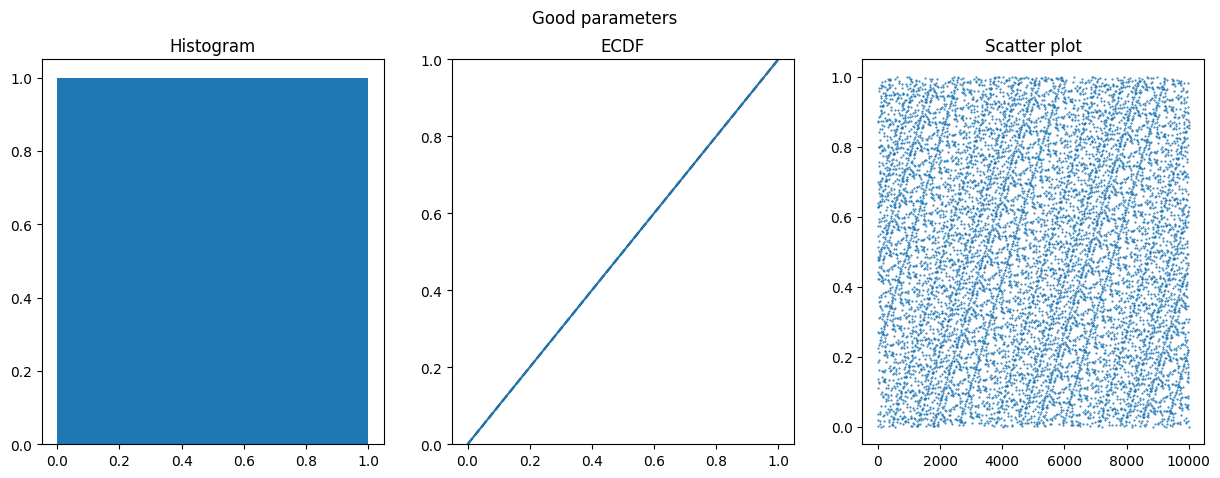

In [10]:
k = 127
n = 10_000
a = 1664521
c = 1013904223
u = lcg(0, a=a, c=c, M=n)


_ = do_tests(u, verbose=True)
plt.suptitle('Good parameters')
plt.show()


Chi-squared: stat=100.50, p-value=0.00
Kolmogorov-Smirnov: stat=0.01, p-value=0.06
Wald-Wolfowitz runs: stat=16.72, p-value=0.00
Up
Knuth up-down: stat=308.92, p-value=0.00
Down
Knuth up-down: stat=312.98, p-value=0.00
Run test III: stat=13.58, p-value=0.00
Correlation: stat=7.46, p-value=0.00


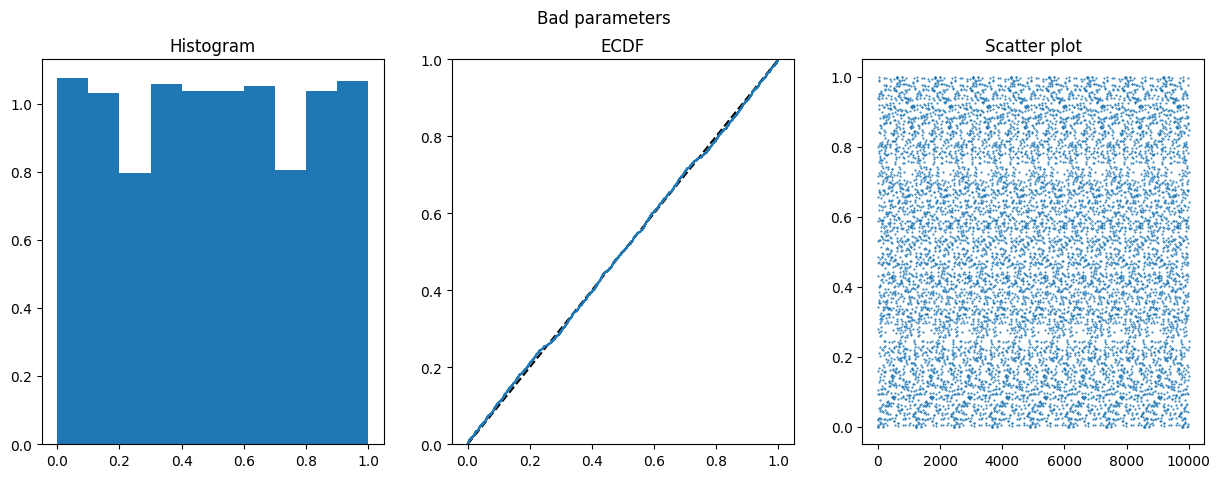

In [11]:
k = 127
n = 10_001
a = 5
c = 6
u = lcg(0, a=a, c=c, M=n)


_ = do_tests(u, verbose=True)
plt.suptitle('Bad parameters')
plt.show()


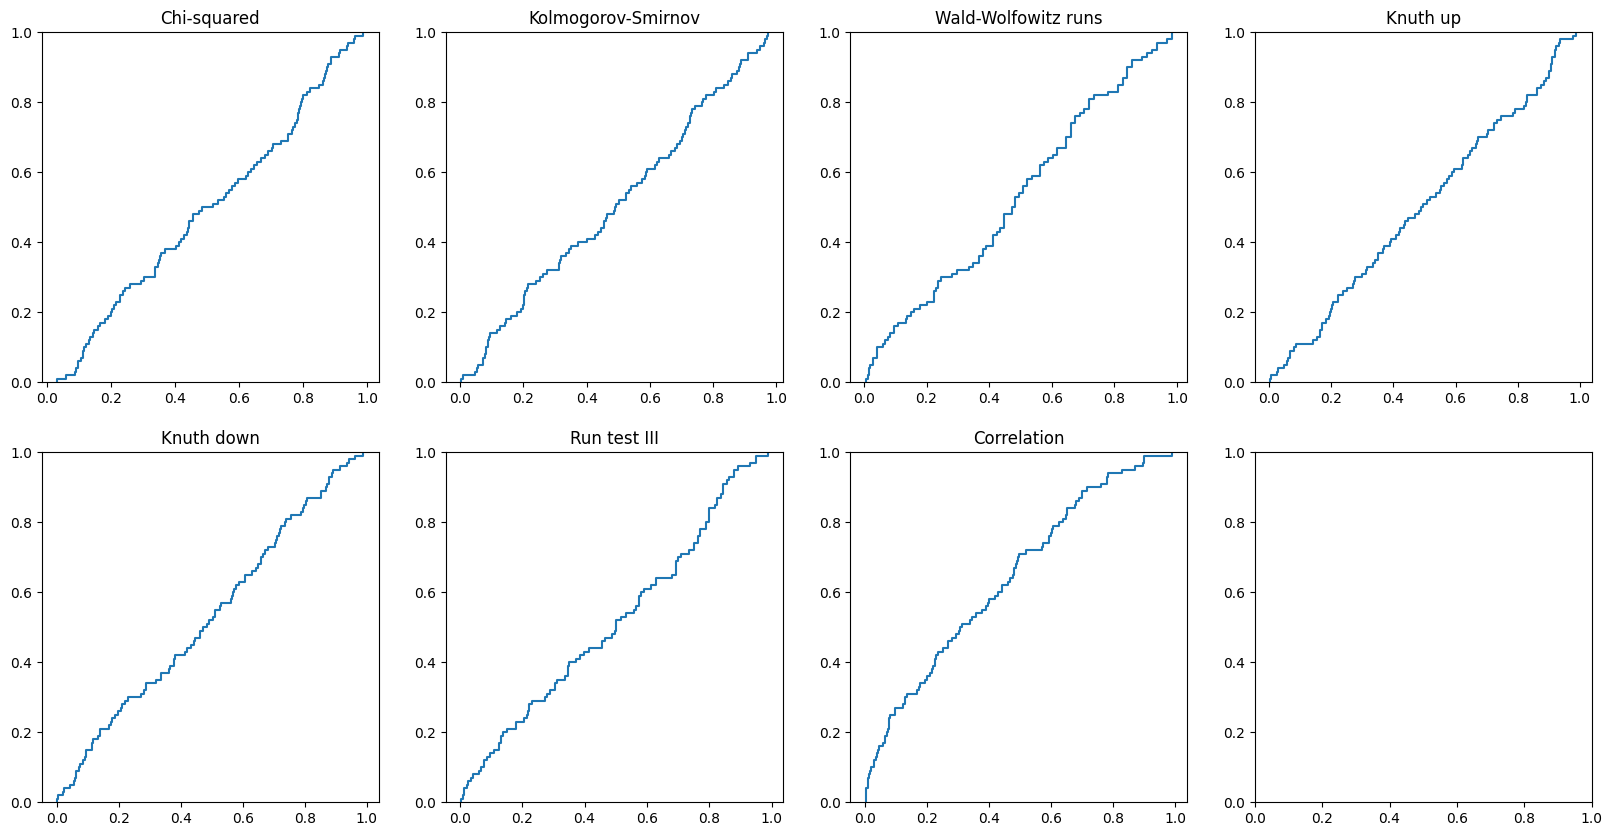

In [12]:
num_random_tests = 100
n = 10_000

results = np.empty((num_random_tests, 7))
for i in tqdm.trange(num_random_tests, leave=False):
    u = np.random.rand(n)
    results[i] = do_tests(u, verbose=False)


fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, (ax, title) in enumerate(zip(
    ax.flatten(),
    ['Chi-squared', 'Kolmogorov-Smirnov', 'Wald-Wolfowitz runs', 'Knuth up', 'Knuth down', 'Run test III', 'Correlation']
)):
    ax.ecdf(results[:, i])
    ax.set_title(title)

# Exercise 2

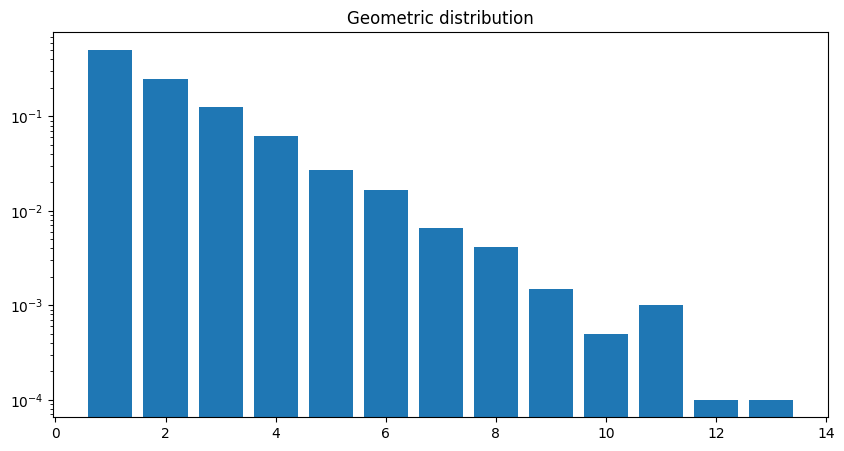

In [39]:
n = 10_000
p = 0.5
u = np.random.rand(n)

geometric = np.floor(np.log(u) / np.log(1 - p)) + 1
num, counts = np.unique(geometric, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(num, counts / n)
plt.yscale('log')
plt.title('Geometric distribution')
plt.show()

In [46]:
def rejection_sampling(p: np.ndarray, n: int) -> np.ndarray:
    assert np.isclose(np.sum(p), 1), 'p must sum to 1'

    k = len(p)
    c = np.max(p)
    p_over_c = p / c
    samples = np.empty(n)
    for i in range(n):
        while True:
            u1, u2 = np.random.rand(2)
            I = int(np.floor(k * u1)) + 1
            if u2 <= p_over_c[I-1]:
                samples[i] = I
                break
    return samples




In [47]:
n = 10_000
p = np.array([7, 5, 6, 3, 12, 15]) / 48

dist_crude = (u < np.cumsum(p)[:, None]).argmax(axis=0) + 1
dist_rejection = rejection_sampling(p, n)

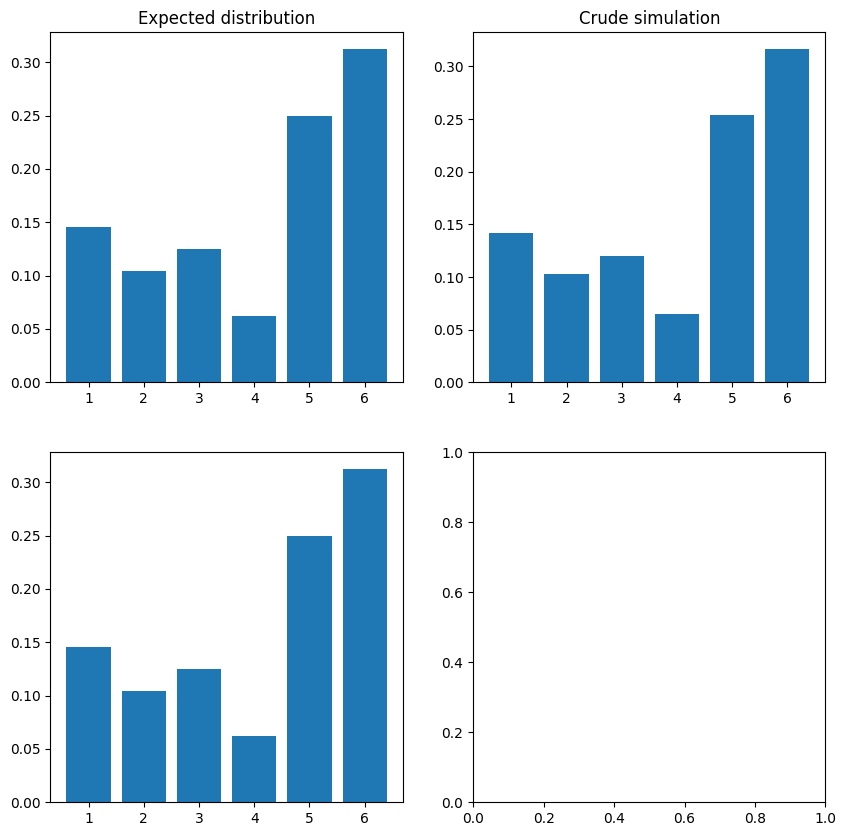

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].bar(np.arange(1, 7), p)
ax[0, 0].set_title('Expected distribution')
ax[0, 1].bar(np.arange(1, 7), np.bincount(dist_crude, minlength=7)[1:] / n)
ax[0, 1].set_title('Crude sampling')
ax[1, 0].bar(np.arange(1, 7), np.bincount(dist_rejection, minlength=7)[1:] / n)
ax[1, 0].set_title('Rejection sampling')

plt.show()

In [ ]:
np.floor(k * u) + 1

array([4., 2., 3., ..., 1., 6., 2.])